In [40]:
# the python script to train the masses with 'BENIGN & MALIGNANT' classess. Here we are treating the 
# soft_tissue, skin_thickening, and nipple_retraction as a same category - soft_tissue.

# importing the required libraries

# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# importing model's modules
from mmdet.models import build_detector
from mmdet.apis import set_random_seed
from mmdet.datasets import build_dataset
from mmdet.apis import train_detector
from mmdet.models import build_detector
from mmcv.runner import load_checkpoint

#importing packiage to be later use
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os.path as osp
from pathlib import Path
import json
from glob import glob
# Check MMDetection installation
import mmdet
print(mmdet.__version__)
import os

# Check mmcv installation
import mmcv
from mmcv import Config
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

1.8.2 False
2.19.0
11.1
GCC 9.3


In [3]:
# Define all the paths

root_path = Path('/home/adil/Desktop/PhD_Data/PhD_Courses/First_Semester/Machine_Learning/Breast_Cancer_Detection/CBIS_DDSM/')
train_json =  str (root_path / 'coco_files/annotations/train.json')
test_json =  str(root_path / 'coco_files/annotations/validation.json')
train_images = str(root_path / 'coco_files/train/')
test_images =  str(root_path / 'coco_files/validation')


In [5]:
# Verify the paths
os.path.exists(test_json)

True

In [10]:
# data verification
with open(test_json, 'r') as f:
    data = json.load(f)
data['categories']

[{'Supercategory': 'Breast_Cancer', 'id': 0, 'name': 'BENIGN'},
 {'Supercategory': 'Breast_Cancer', 'id': 1, 'name': 'MALIGNANT'}]

In [16]:
config_path = str(root_path / 'Breast_detection_model/model/mask_rcnn/configs/mask_rcnn/mask_rcnn_r50_caffe_fpn_mstrain-poly_1x_coco.py')
cfg = Config.fromfile(config_path)

In [17]:
classes = ('BENIGN','MALIGNANT')

In [18]:
# Reading dataset type
cfg.dataset_type = 'COCODataset'

# reading the data 
cfg.data.test.ann_file = test_json
# cfg.data.test.img_prefix = None
cfg.data.test.classes = classes


cfg.data.train.ann_file = train_json
# cfg.data.train.img_prefix = None
cfg.data.train.classes = classes


cfg.data.val.ann_file = test_json
# cfg.data.test.img_prefix = None
cfg.data.val.classes = classes

In [61]:
# building dataset
dataset = build_dataset(cfg.data.train)
dataset, dataset.coco.cats

loading annotations into memory...
Done (t=0.73s)
creating index...
index created!


(
 CocoDataset Train dataset with number of images 2354, and instance counts: 
 +------------+-------+---------------+-------+----------+-------+----------+-------+----------+-------+
 | category   | count | category      | count | category | count | category | count | category | count |
 +------------+-------+---------------+-------+----------+-------+----------+-------+----------+-------+
 |            |       |               |       |          |       |          |       |          |       |
 | 0 [BENIGN] | 1630  | 1 [MALIGNANT] | 1120  |          |       |          |       |          |       |
 +------------+-------+---------------+-------+----------+-------+----------+-------+----------+-------+,
 {0: {'Supercategory': 'Breast_Cancer', 'id': 0, 'name': 'BENIGN'},
  1: {'Supercategory': 'Breast_Cancer', 'id': 1, 'name': 'MALIGNANT'}})

In [25]:
dataset.coco.anns[1].keys()

dict_keys(['segmentation', 'area', 'iscrowd', 'image_id', 'bbox', 'category_id', 'id', 'Data_dict'])

In [72]:
dataset.coco.anns[ann_ids]

{'segmentation': [[1464,
   1640,
   1464,
   1641,
   1463,
   1642,
   1462,
   1643,
   1461,
   1642,
   1460,
   1643,
   1459,
   1644,
   1458,
   1645,
   1457,
   1646,
   1456,
   1646,
   1455,
   1646,
   1454,
   1645,
   1454,
   1644,
   1454,
   1643,
   1455,
   1642,
   1454,
   1643,
   1453,
   1642,
   1452,
   1643,
   1451,
   1644,
   1450,
   1645,
   1449,
   1645,
   1448,
   1645,
   1447,
   1645,
   1446,
   1645,
   1445,
   1645,
   1444,
   1645,
   1443,
   1645,
   1442,
   1645,
   1441,
   1644,
   1440,
   1645,
   1439,
   1646,
   1438,
   1646,
   1437,
   1647,
   1436,
   1647,
   1435,
   1647,
   1434,
   1647,
   1433,
   1647,
   1432,
   1646,
   1432,
   1645,
   1431,
   1646,
   1430,
   1647,
   1429,
   1648,
   1428,
   1648,
   1427,
   1649,
   1426,
   1649,
   1425,
   1648,
   1424,
   1647,
   1423,
   1648,
   1422,
   1649,
   1421,
   1648,
   1422,
   1649,
   1422,
   1650,
   1422,
   1651,
   1421,
   1652,
   1422,
   

In [106]:
ann_metadata['Data_dict']['abnormality_type'].upper()

'MASS'

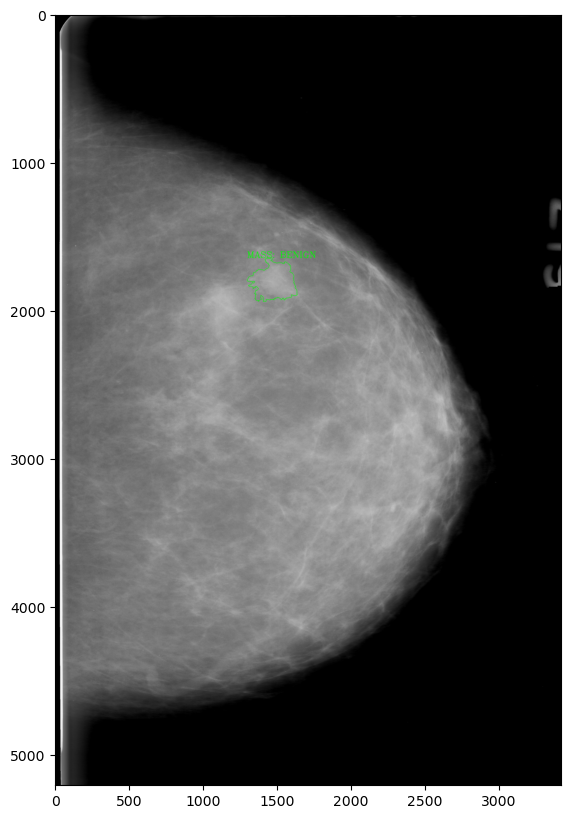

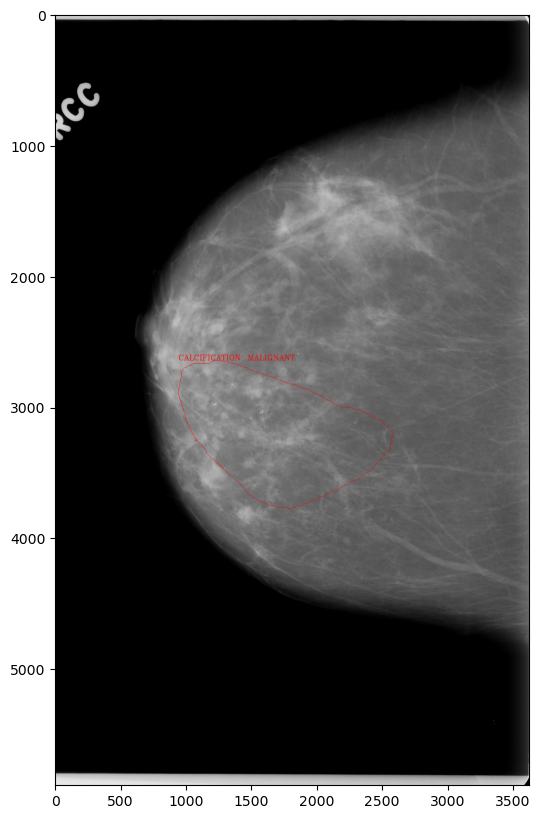

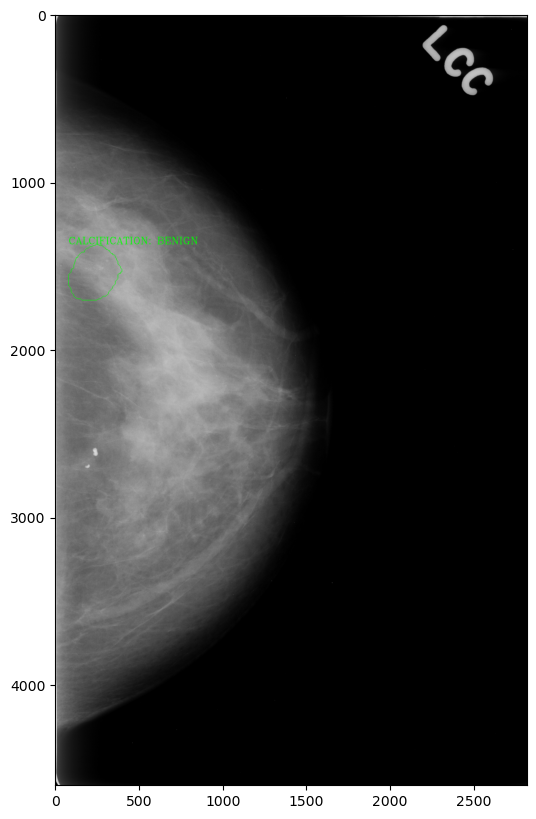

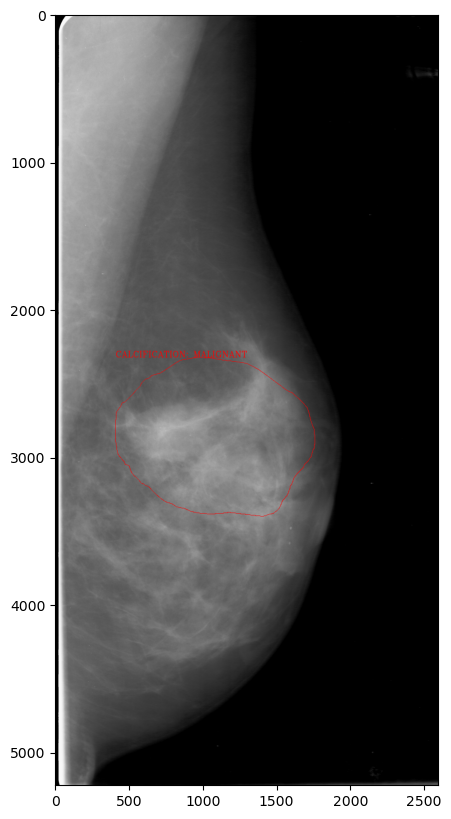

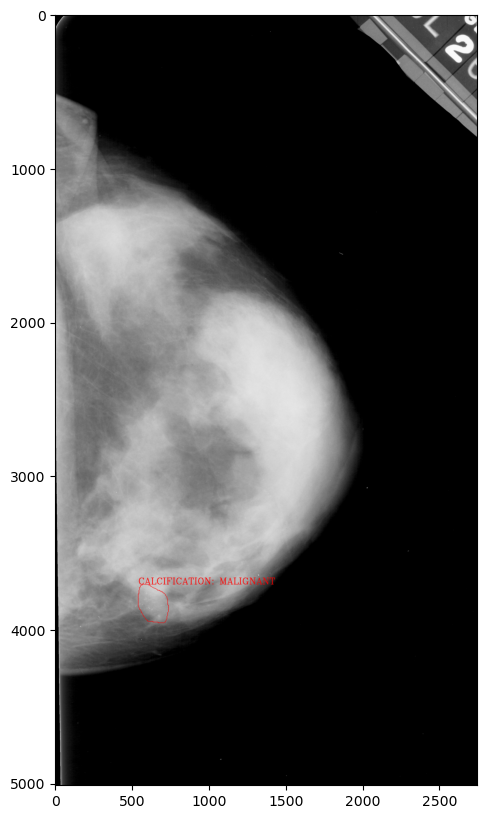

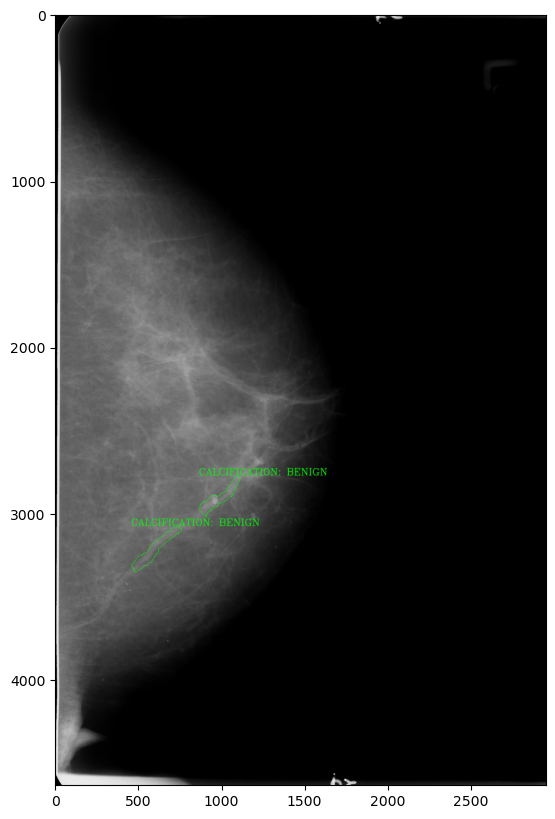

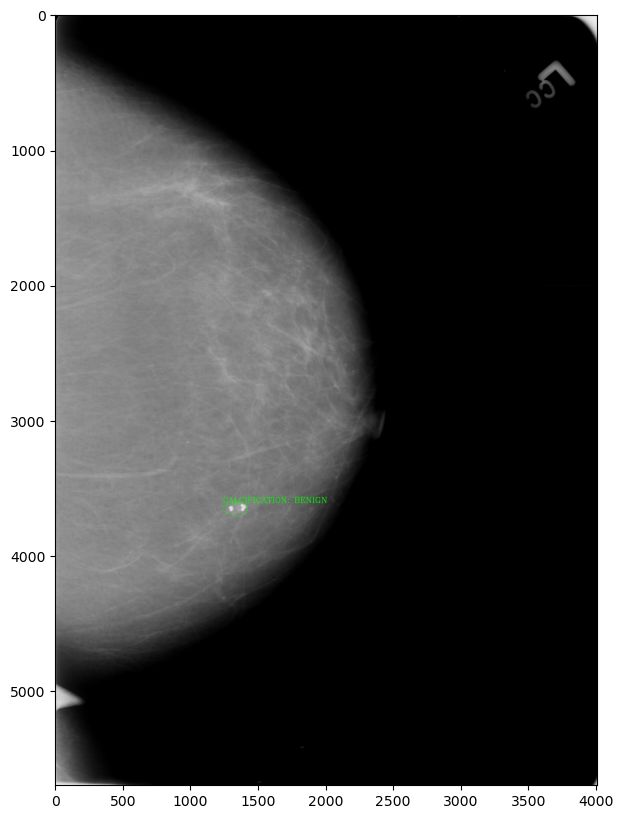

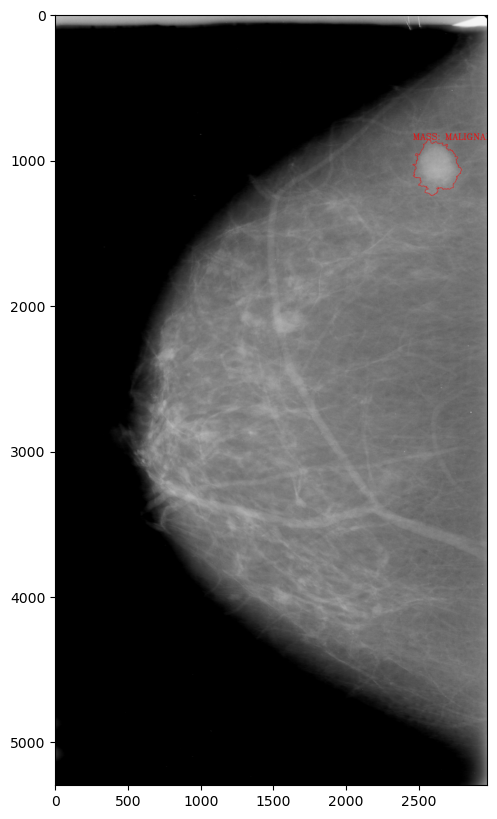

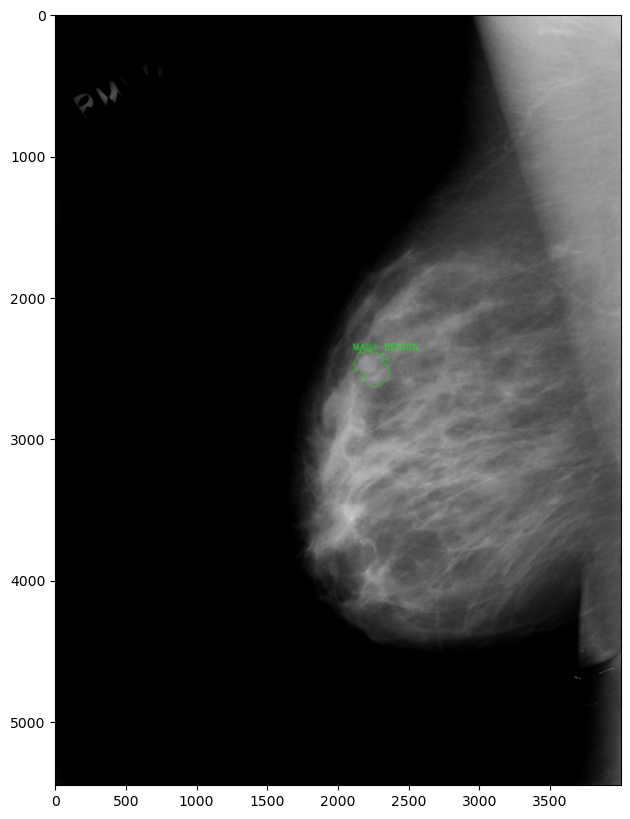

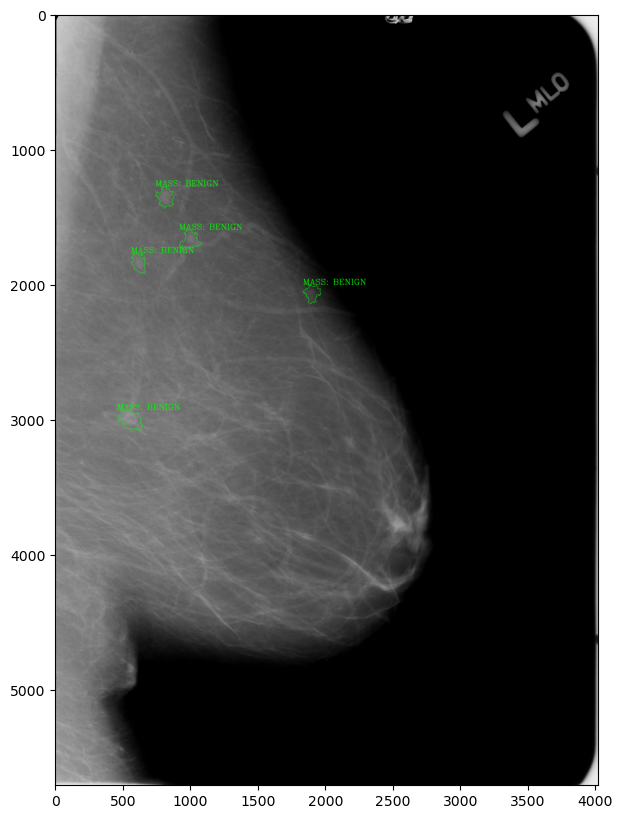

In [108]:
# lets visualize the results
for img_ids in dataset.coco.get_img_ids()[:10]:
    filename = dataset.coco.imgs[img_ids]['file_name']
    img = cv2.imread(str(root_path) + '/' + 'coco_files/train/' + filename)
    if img is None: continue
    org_img = img.copy()
    for ann_ids in dataset.coco.get_ann_ids(img_ids):
        ann_metadata = dataset.coco.anns[ann_ids]
        abnormality_type = ann_metadata['Data_dict']['abnormality_type'].upper()
        mask = dataset.coco.annToMask(ann_metadata)
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        if len(contours) == 0: continue
        contours = sorted(contours, key=lambda x: len(x), reverse=True)[0]
        x,y,w,h = cv2.boundingRect(contours)
        target_name = dataset.coco.cats[dataset.coco.anns[ann_ids]['category_id']]['name']
        if target_name == 'BENIGN':
            cv2.drawContours(org_img, contours, -1, (0, 255, 0), 2)
            cv2.putText(org_img, '{}: {}'.format(abnormality_type, str(target_name)), (x, y), cv2.FONT_HERSHEY_COMPLEX, 2, (0, 255, 0), 2)
        if target_name =='MALIGNANT':
            cv2.drawContours(org_img, contours, -1, (255, 0, 0), 2)
            cv2.putText(org_img, '{}: {}'.format(abnormality_type, str(target_name)), (x,y), cv2.FONT_HERSHEY_COMPLEX, 2, (255, 0, 0), 2)
            
    plt.figure(figsize=(10, 10))
    plt.imshow(org_img)
    plt.show()